# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение, в котором можно узнать рыночную стоимость автомобиля.  
В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Требуется построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта**: протестировать несколько моделей машинного обучения для прогнозирования рыночной цены автомобиля. Проанализировать полученные модели и выбрать более подходящую модель под критерии заказчика.

## Подготовка данных

### Импорт библиотек, загрузка данных

In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np

# Графики
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Статистика
from statistics import mode as mode
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

# LightGBM
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
df = pd.read_csv('/content/autos.csv')

### Изучение данных

In [3]:
print(f'Количество строк: {df.shape[0]}, количество столбцов: {df.shape[1]}')

Количество строк: 354369, количество столбцов: 16


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
display(df.head(3))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Наблюдаем, что в датасете 354369 строк, 16 столбцов. Названия столбцов не приведены к нижнему регистру, в некоторых столбцах имеются пропуски, типы данных соответствуют представленным данным.

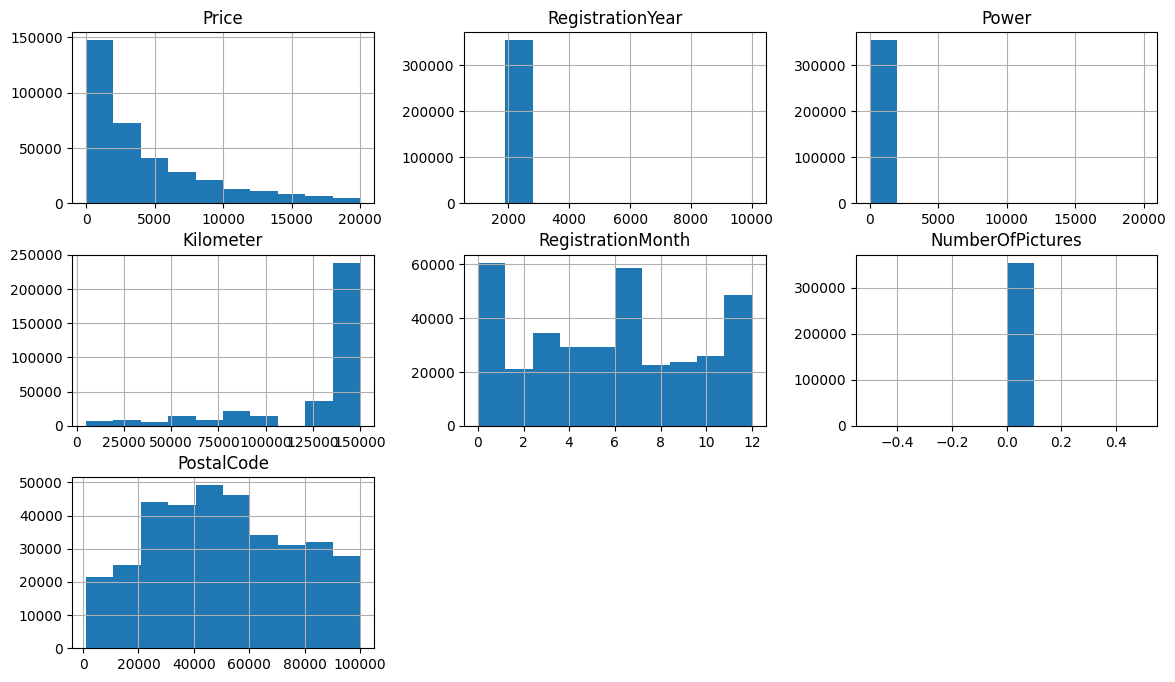

In [6]:
df.hist(figsize=(14,8))
plt.show()

Возможны аномалии в столбцах с годом регистрации и мощностью.

### Предобработка данных

#### Приведение названия столбцов к нижнему регистру

In [7]:
df.columns = df.columns.str.lower()

In [8]:
# проверка названий колонок
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

#### Работа с пропусками, работа с выбросами

In [9]:
print(df.isna().sum().sort_values(ascending=False))

repaired             71154
vehicletype          37490
fueltype             32895
gearbox              19833
model                19705
datecrawled              0
price                    0
registrationyear         0
power                    0
kilometer                0
registrationmonth        0
brand                    0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64


Наблюдаем наличие пропусков в пяти признаках: repaired, vehicletype, fueltype, gearbox, model

In [10]:
# столбец repaired
df['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Проверим какая доля автомобилей, зарегистрированных до 2010 года была в ремонте. После этого заполним пропуски в столбце repaired

In [11]:
print(np.array(sorted(df['registrationyear'].unique())))

[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


Наблюдаем, что в столбце registrationyear присутствуют аномалии. Так, минимальный год регистрации автомобиля - 1000, а максимальный = 9999. Признаём аномалиями все данные выше 2019 года. А для определения нижнего порога построим боксплот

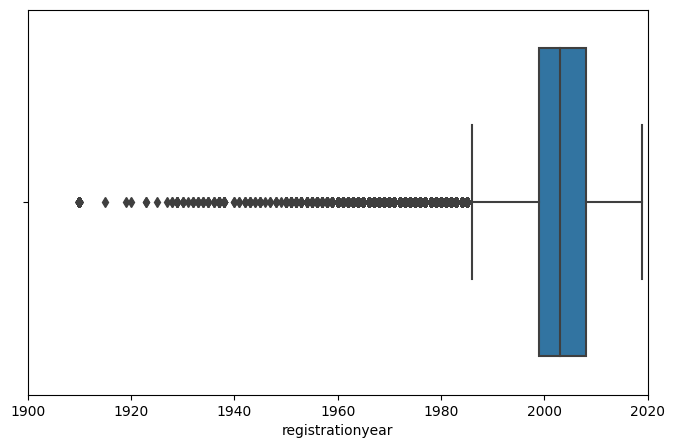

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

In [12]:
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
sns.boxplot(data=df, x='registrationyear')
plt.gca().set_xlim([1900, 2020])
plt.show()

df['registrationyear'].describe()

Можно понять, что "нижний ус" начинается на отметке 1985. Остальное признаём выбросами и удаляем

In [13]:
# Посчитаем долю выбросов в столбце registrationyear
print((df.loc[(df['registrationyear']<1985) | (df['registrationyear']>2019)]['registrationyear'].count()/df.shape[0])*100)
# Выбросы составляют 1,57%, поэтому удаляем

1.5670106583815175


In [14]:
# Удаляем аномалии в столбце registrationyear
df = df.loc[(df['registrationyear']>1984) & (df['registrationyear']<2020)]
# Проверяем значения
print(np.array(sorted(df['registrationyear'].unique())))

[1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019]


In [15]:
pd.to_datetime(df['datecrawled']).describe()

count                  348816
unique                 268092
top       2016-03-19 21:49:56
freq                        6
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: datecrawled, dtype: object

In [16]:
# Посчитаем долю машин, которые были в ремонте
print(f'Доля машин, побывавших в ремонте: {round(((df.loc[df["repaired"]=="yes"]["repaired"].count())/df.shape[0])*100, 2)}')
print()

repaired_by_year = df.loc[df["repaired"]=="yes"].value_counts(["registrationyear"], sort = False)
all_cars_by_year = (df.value_counts('registrationyear', sort = False))
share_repaired_by_year = pd.Series(repaired_by_year.values/all_cars_by_year.values, index = all_cars_by_year.index)

Доля машин, побывавших в ремонте: 10.19



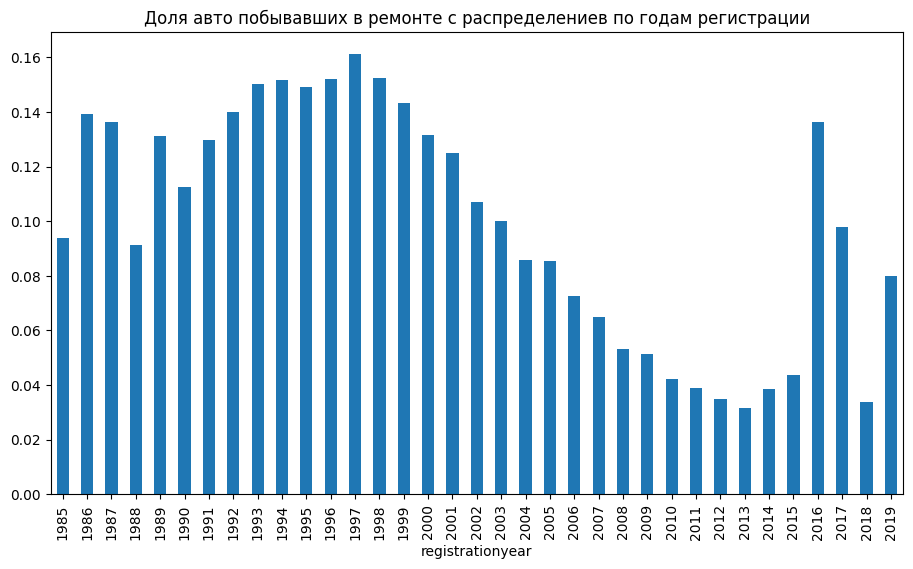

count    35.000000
mean      0.099667
std       0.043036
min       0.031469
25%       0.058986
50%       0.100086
75%       0.137939
max       0.161121
dtype: float64

In [17]:
# Распределение ромонтируемых машин во времени
share_repaired_by_year.plot(kind = 'bar', figsize = (11,6))
plt.title('Доля авто побывавших в ремонте с распределениев по годам регистрации')
plt.show()
share_repaired_by_year.describe()


Можем наблюдать, что кол-во автомобилей зарегистрированных в 1986-1987, 1989-2002 и в 2016гг. были в ремонте гораздо чаще среднего значения. Так, например, в 1997 году доля авто, которые были в ремонте составила 16%, в то время как среднее значение показателя около 10%. Так, понимаем, что в 1997 году показатель превышает среднее значение на 60%.

Тем не менее, мне не представляется возможным заполнить пропуски в столбце repaired в зависимость от года регистрации, поэтому, заполним их заглушкой unknown

In [18]:
# заполнение пропусков в столбце repaired
df['repaired'] = df['repaired'].fillna('unknown')
# проверим заполнение
print(f'Количество пропусков: {df["repaired"].isna().sum()}')
print(df['repaired'].unique())

Количество пропусков: 0
['unknown' 'yes' 'no']


In [19]:
# столбец vehicletype
df['vehicletype'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Заполним пропуски в столбце vehicletype по самым распространенным типам кузова модели

In [20]:
# Проверим, если есть пропуски в названиях модели в тех объектах, где есть пропуски в типе кузова
df.loc[(df['vehicletype'].isna()) & (df['model'].isna())]['registrationyear'].count()
# Да, присутвтвет 6471 объект, поэтому сначала заполним пропуски в столбце model

6471

Заполним модель автомобиля с помощью марки и мощности.  
Проверим на нескольких брендах, будет ли существенно отличаться среднняя мощность автомобиля в зависимость от модели.

In [21]:
# создадим функцию
df.loc[df['brand']=='volkswagen']['power']
def model_power(brand):
    model_list = []
    power_list = []
    for model in (df.loc[df['brand']== brand]['model']).unique():
        model_list.append(model)
        power_list.append(df.loc[df['model']==model]['power'].mean())
    model_power = (pd.Series(index=model_list, data=power_list))
    model_power.plot(kind = 'bar', figsize = (10,5))
    plt.title(f'Средняя мощность авто в зависимости от модели. {brand}')
    plt.show()
    print(model_power.describe())

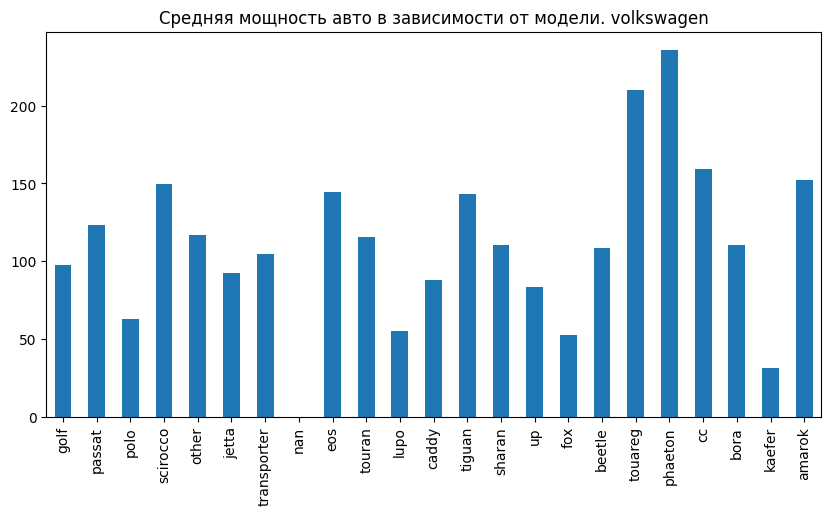

count     22.000000
mean     115.788622
std       48.748440
min       31.602273
25%       89.092341
50%      110.261502
75%      143.998946
max      235.869159
dtype: float64


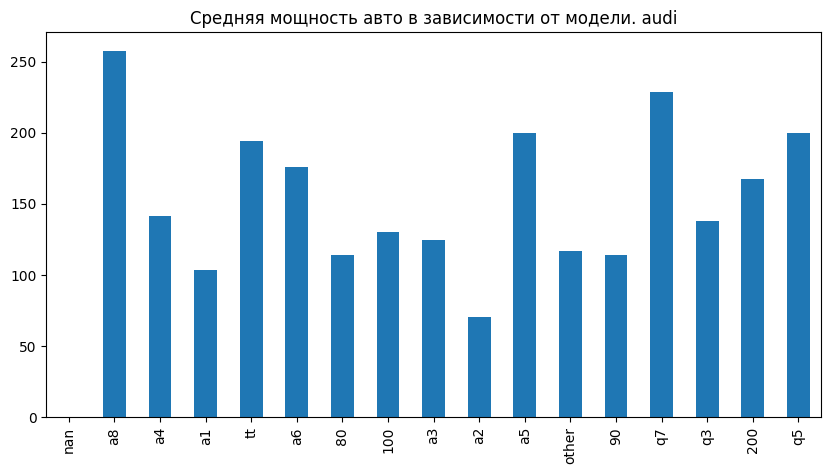

count     16.000000
mean     154.895698
std       50.798104
min       70.822581
25%      116.206401
50%      139.774740
75%      195.748720
max      257.773157
dtype: float64


In [22]:
model_power('volkswagen')
model_power('audi')

На примере volkswagen и audi можем наблюдать, что разница между некоторыми моделями существенна.  
Выделим три категории мощности для каждого бренда и внутри каждой категории модой выберем модель авто.  
Но перед этим рассмотрим столбец с мощностями на аномалии.

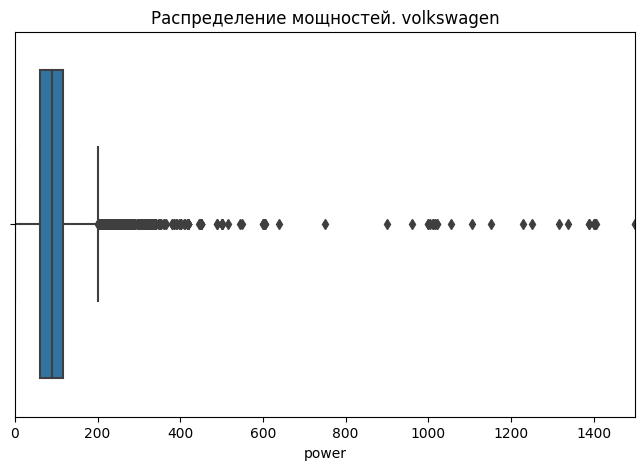

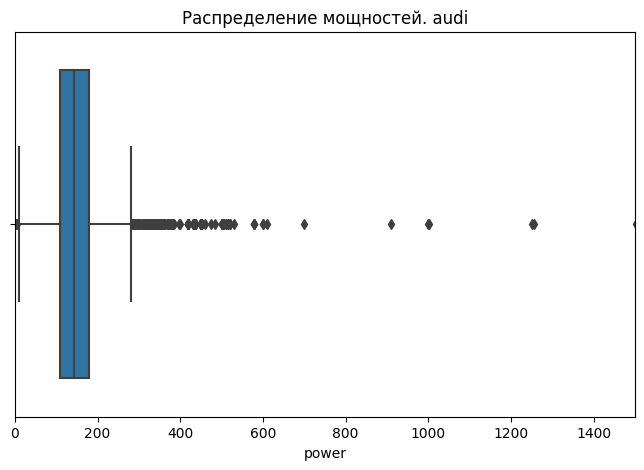

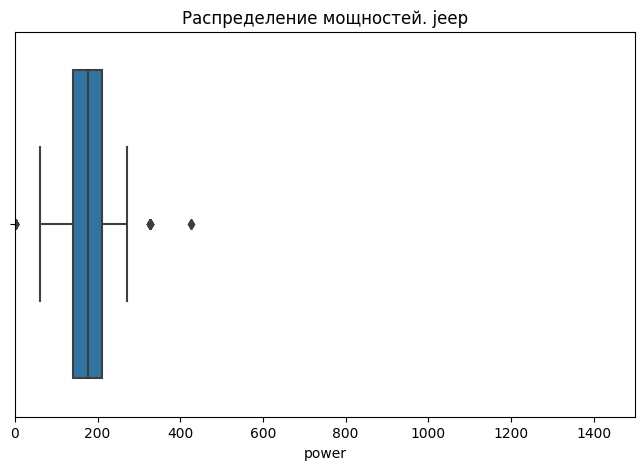

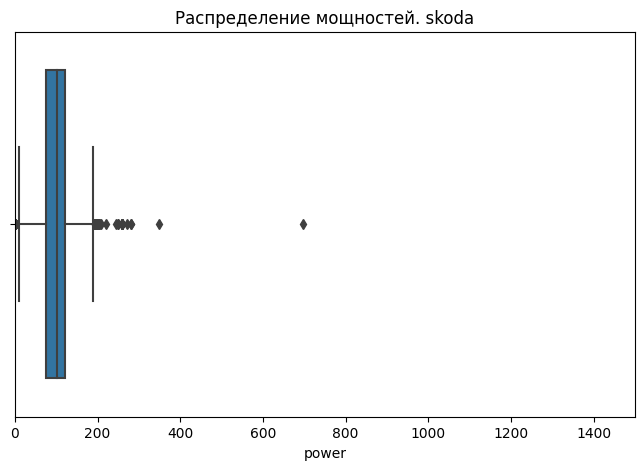

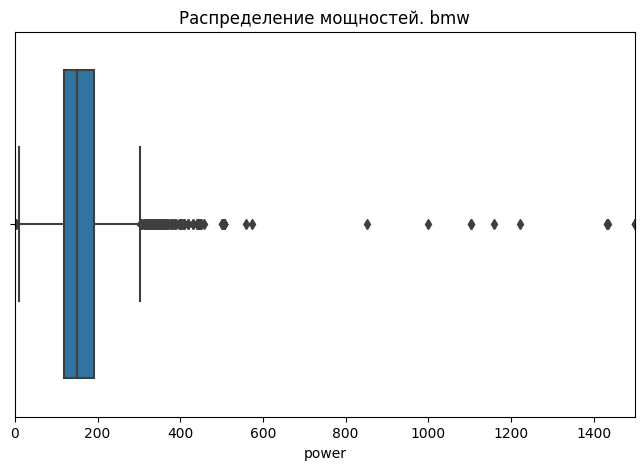

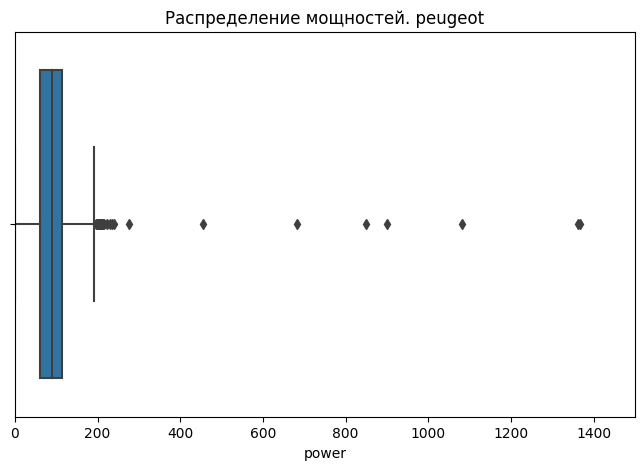

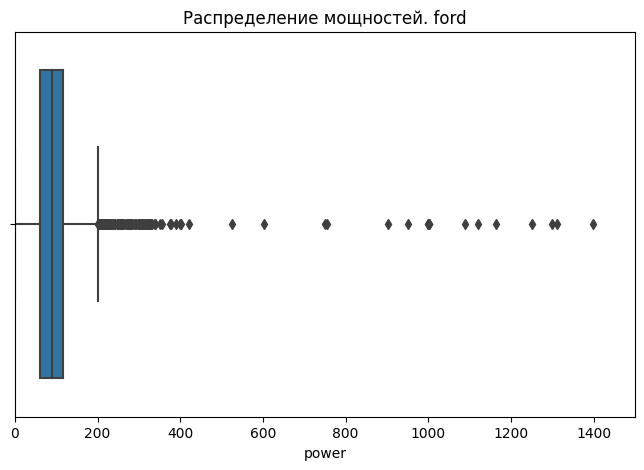

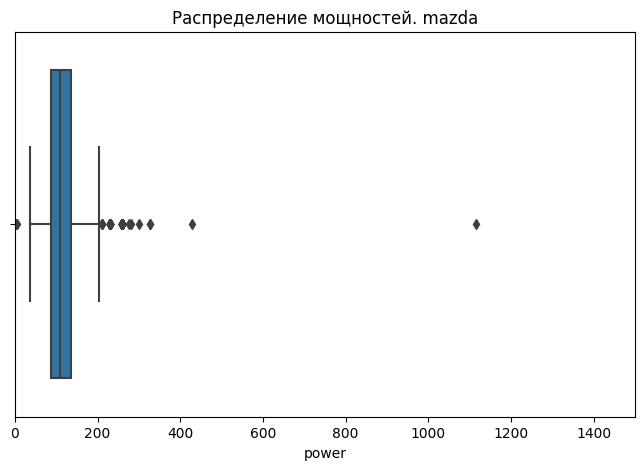

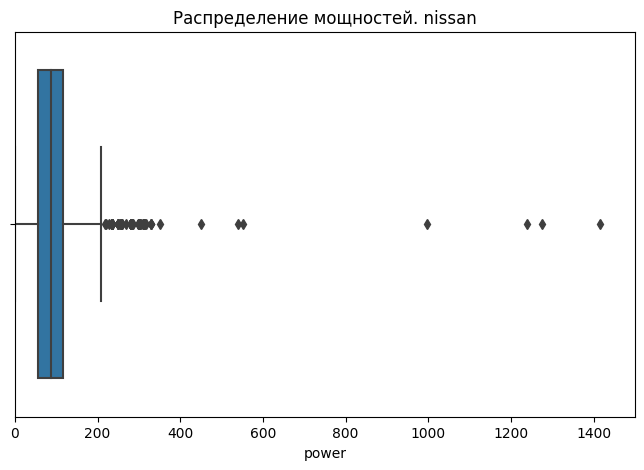

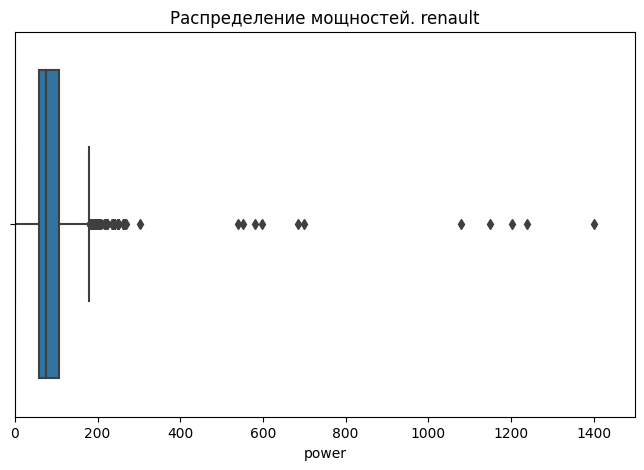

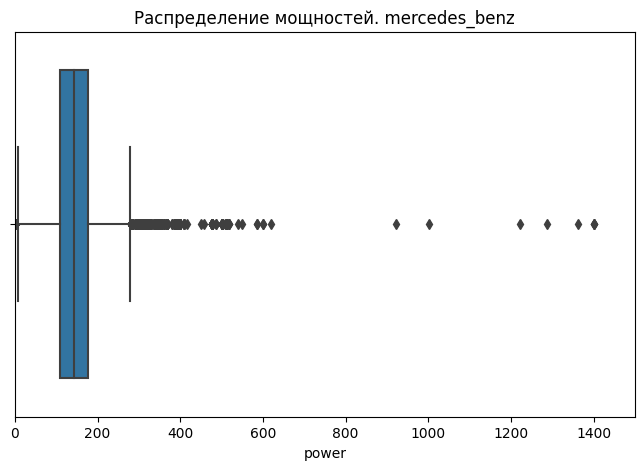

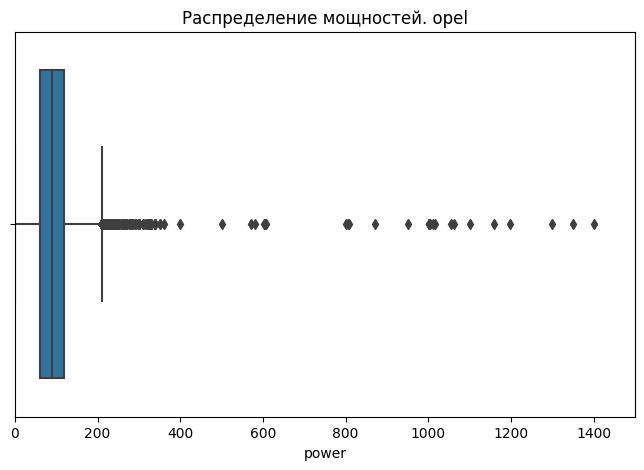

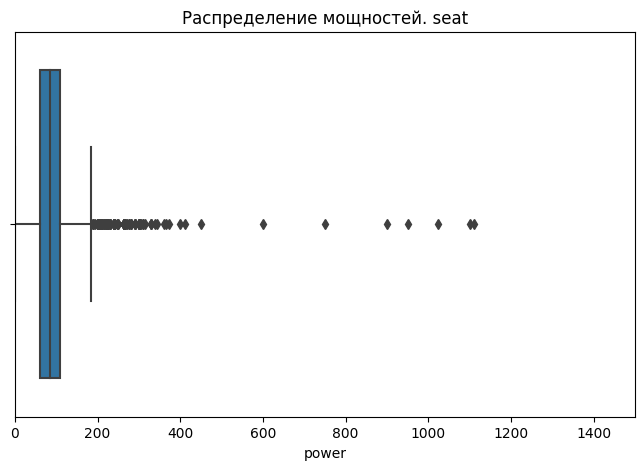

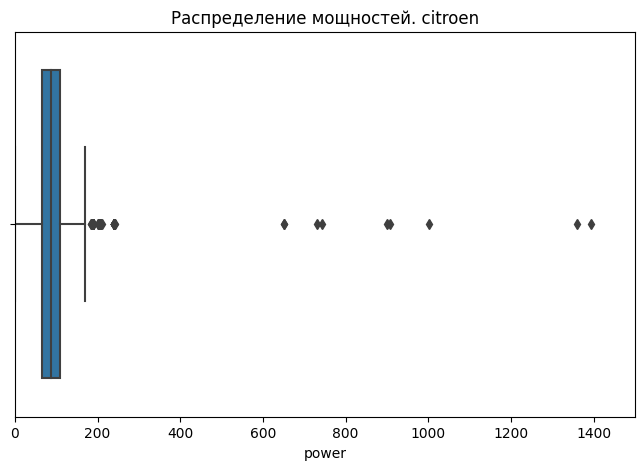

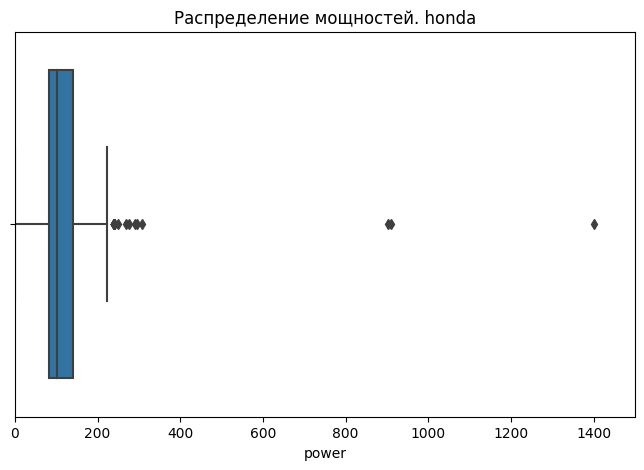

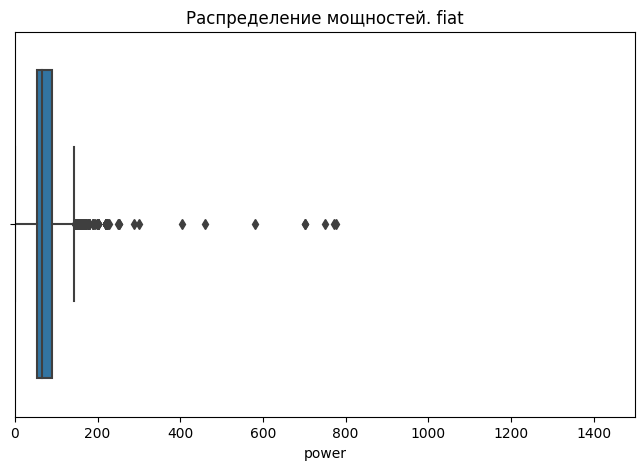

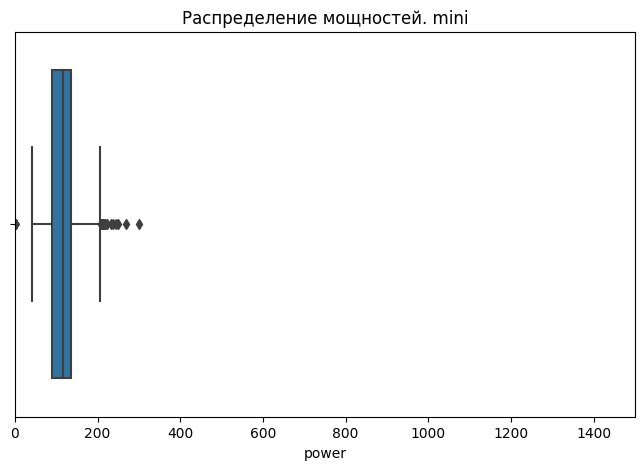

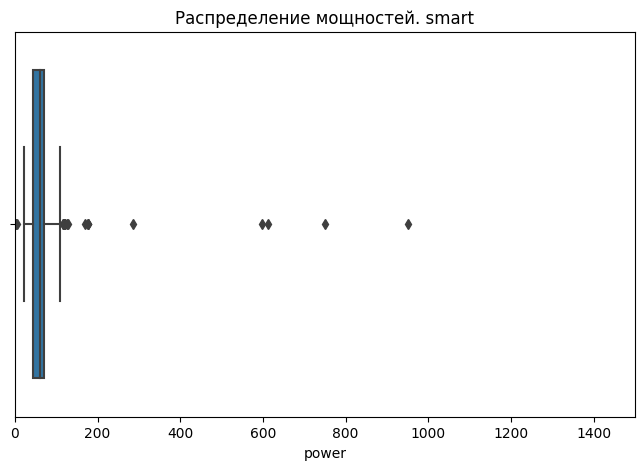

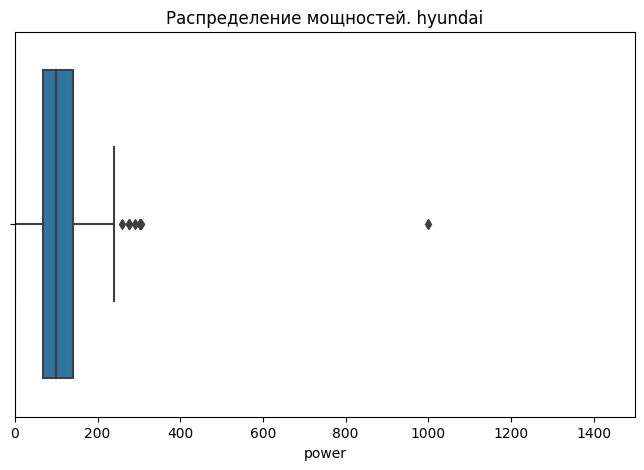

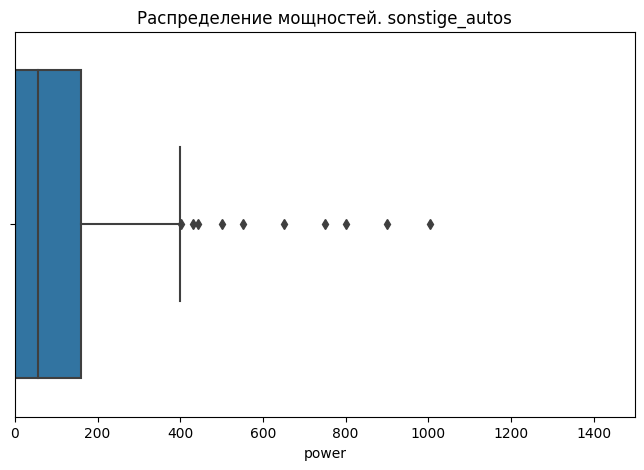

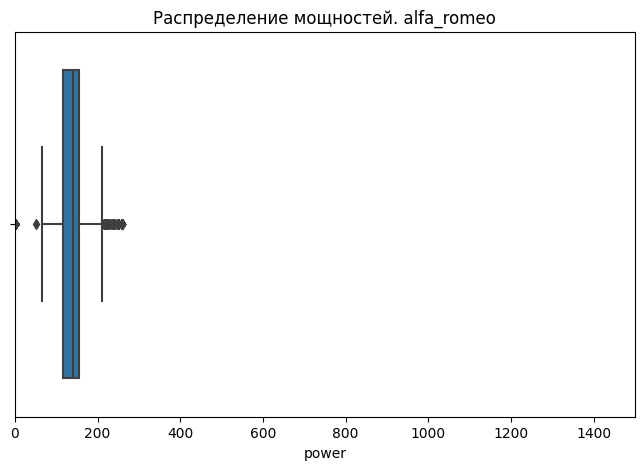

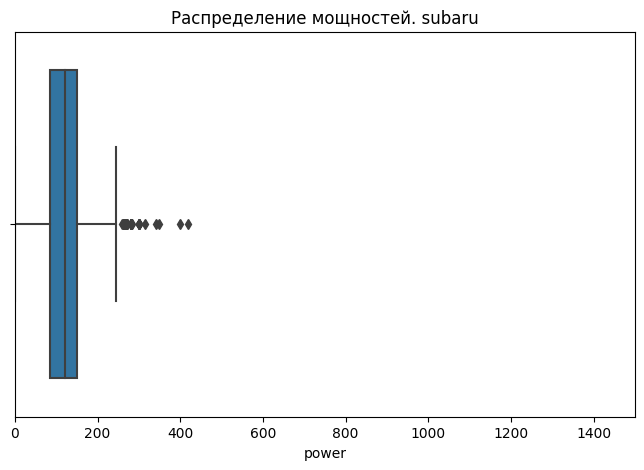

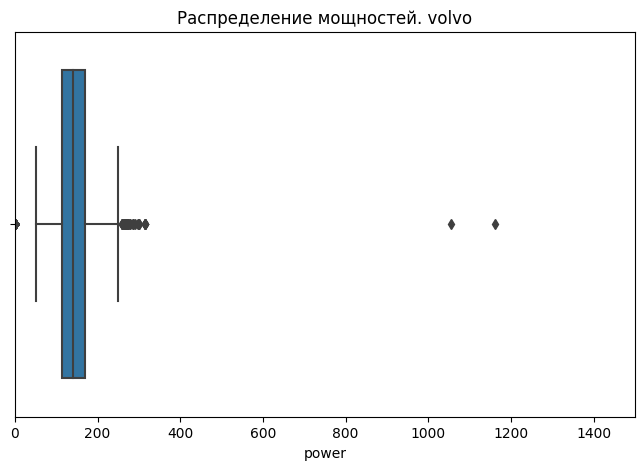

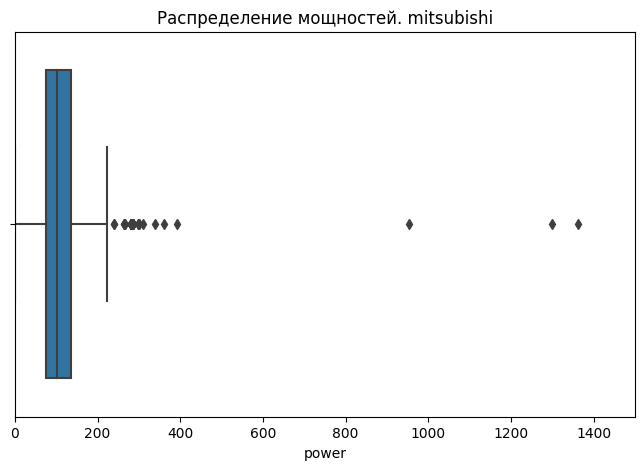

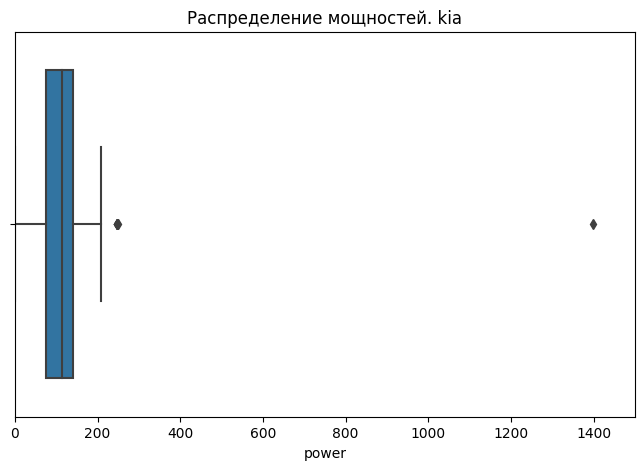

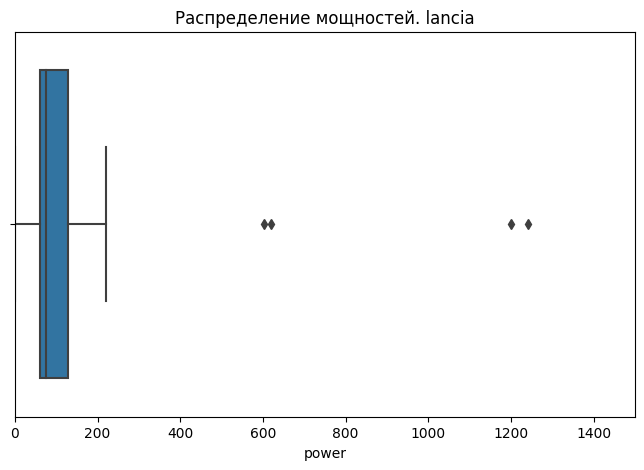

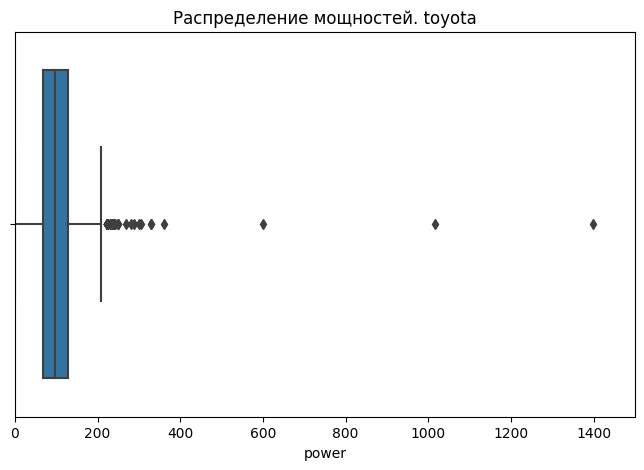

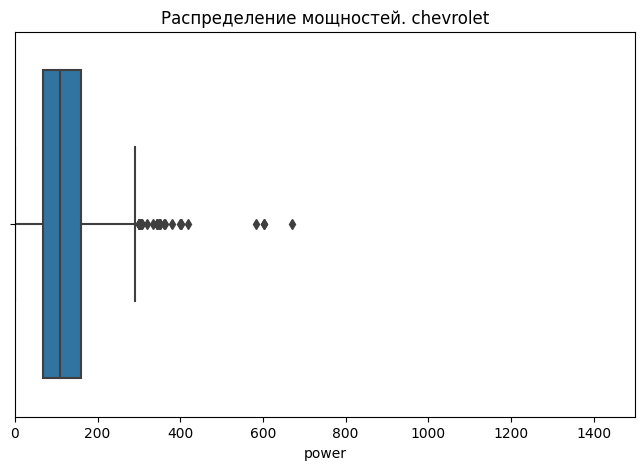

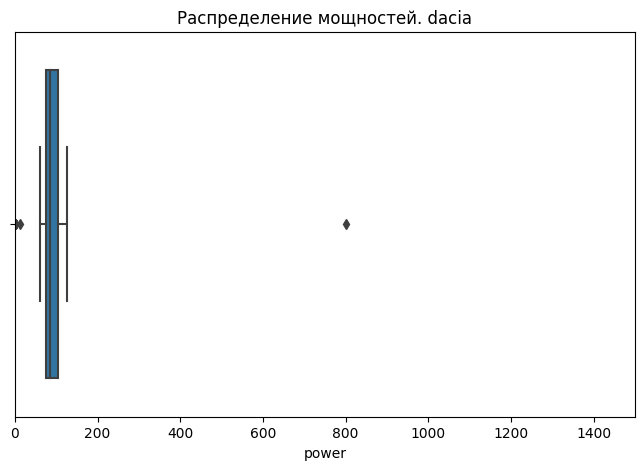

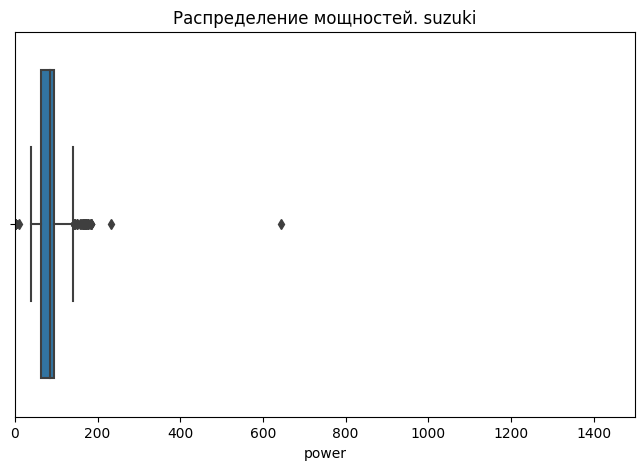

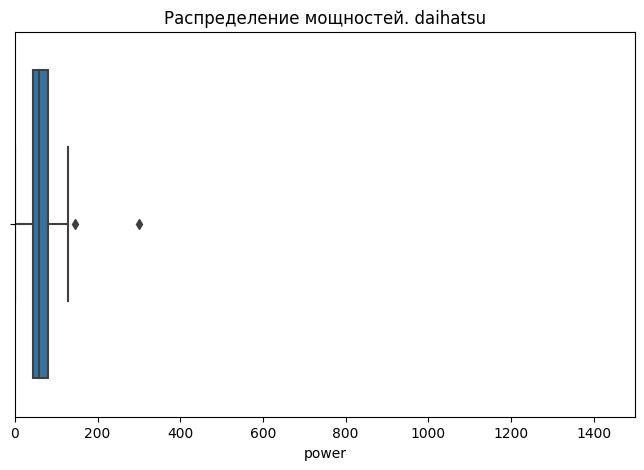

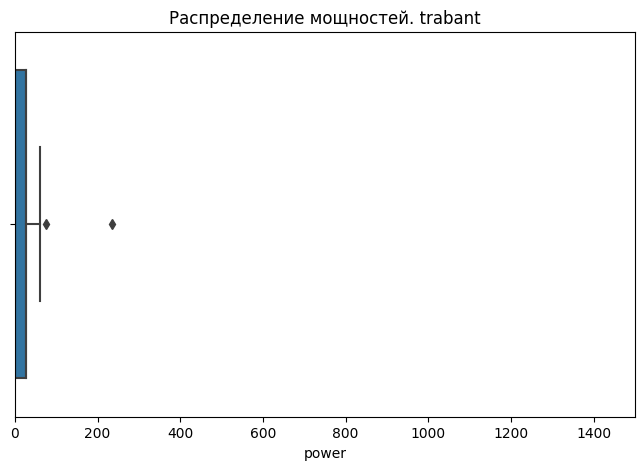

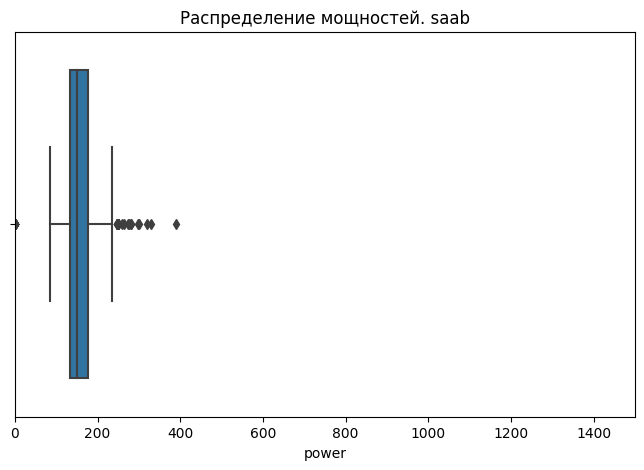

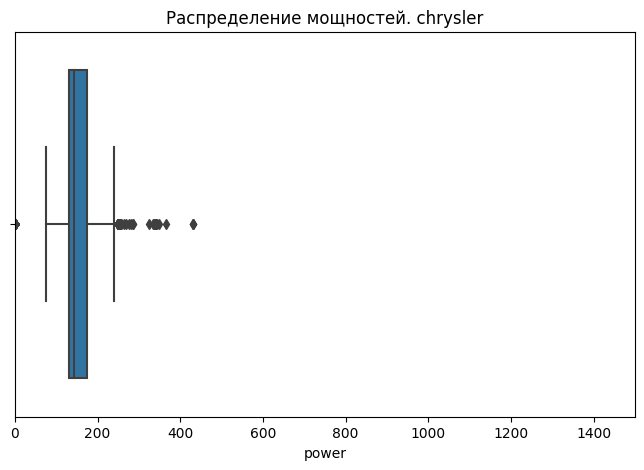

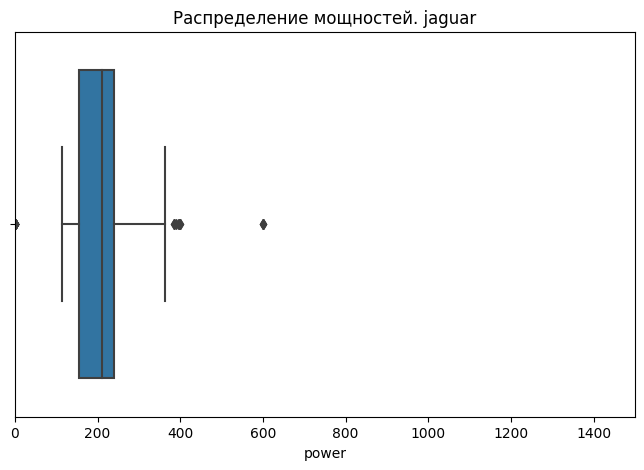

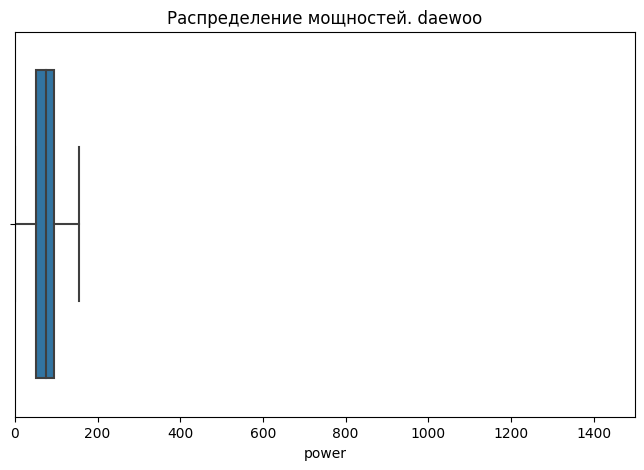

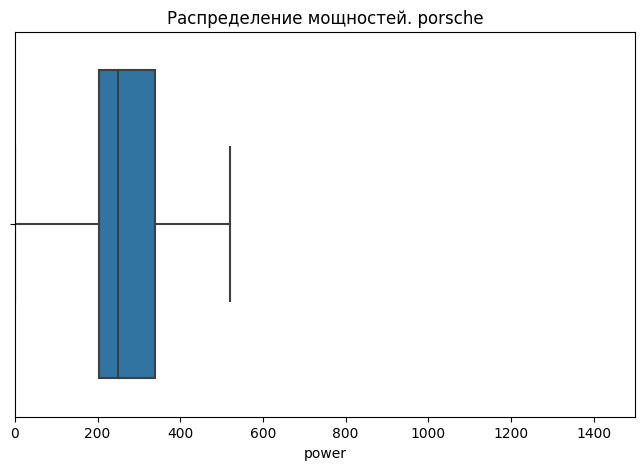

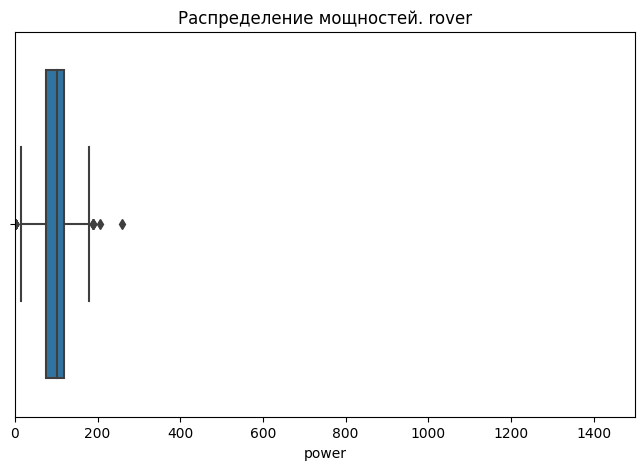

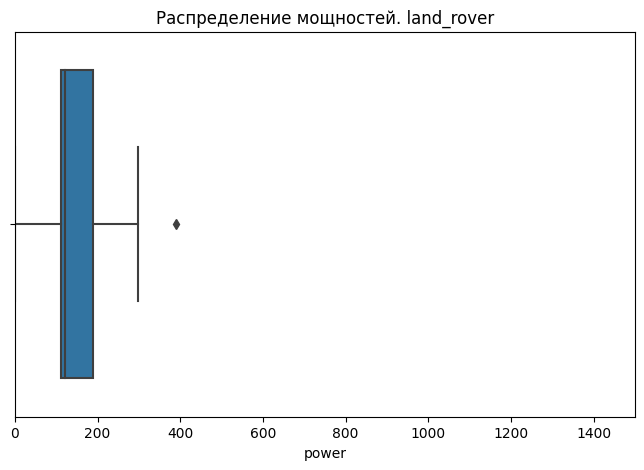

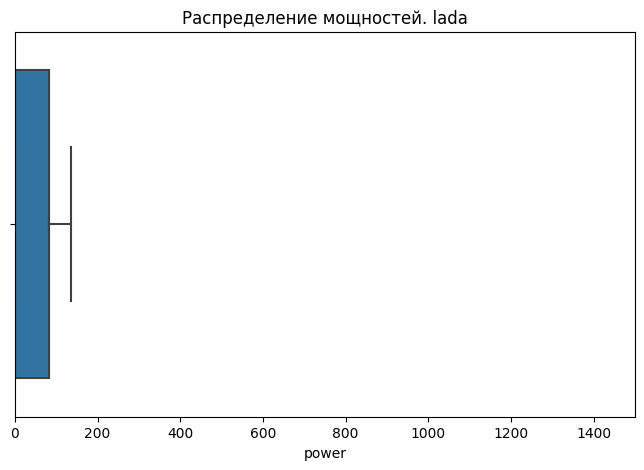

In [36]:
for brand in df['brand'].unique():
    fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
    sns.boxplot(data=df.loc[df['brand'] == brand], x='power')
    plt.gca().set_xlim([0, 1500])
    plt.title(f'Распределение мощностей. {brand}')
    plt.show()
    plt.close()

Наблюдаем очень большое кол-во значений, которые во много раз превосходят медиану.  
Предполагаем, что в выборке могут быть представлены объекты в спортивной сборке, поэтому нельзя просто удалить все объекты, которые находятся на числовой оси дальше "правого уса". По данной причине принято решение расширить область допустимых значений с 1,5 до 3-х межквартильных размахов.

In [37]:
# Удалим выбросы в столбце power:
for brand in df['brand'].unique():
    q1, q3 = np.percentile(df.loc[df['brand']==brand]['power'], [25, 75])
    iqr = q3 - q1
    upper_bound = q3 + 3 * iqr
    df.loc[(df['brand']==brand)] = df.loc[(df['brand']==brand) & (df['power']<upper_bound)]

In [38]:
# Удалим пропуски в графе бренд
df = df.loc[~df['brand'].isna()]

In [39]:
# Замечаем также, что у sonstige_autos вообще отсутствуют названия моделей. Поэтому заполним их sonstige_autos
df.loc[(df['brand']=='sonstige_autos') & (df['model'].isna()), 'model'] = 'sonstige_autos'

Заполним модель авто:

In [40]:
for brand in df['brand'].unique():
    q1, q3 = np.percentile(df.loc[df['brand']==brand]['power'], [25, 75])

    df.loc[(
            df['brand']==brand) & (df['model'].isna()) & (df['power']<=q1), 'model'] = df.loc[(
            df['brand']==brand) & (df['power']<=q1), 'model'].mode()[0]
    df.loc[(
            df['brand']==brand) & (df['model'].isna()) & (df['power']<=q3) & (df['power']>q1), 'model'] = df.loc[(
            df['brand']==brand) & (df['power']<=q3) & (df['power']>q1), 'model'].mode()[0]
    df.loc[(
            df['brand']==brand) & (df['model'].isna()) & (df['power']>q3), 'model'] = df.loc[(
            df['brand']==brand) & (df['power']>q3), 'model'].mode()[0]


Заполним пропуски в столбце vehicletype по самым распространенным типам кузова модели

In [41]:
df.loc[df['model']=='serie_2', 'vehicletype'] = 'unknown'

In [42]:
for model in df['model'].unique():
    df.loc[(
        df['model']==model) & (df['vehicletype'].isna()), 'vehicletype'] = df.loc[(
        df['model']==model), 'vehicletype'].mode()[0]

In [43]:
# Проверим наличие пропусков в типе кузова:
df['vehicletype'].isna().sum()

0

In [44]:
# Заполним пропуски в столбцах fueltype и gearbox формулировкой unknown
df.loc[df['fueltype'].isna(), 'fueltype'] = 'unknown'
df.loc[df['gearbox'].isna(), 'gearbox'] = 'unknown'

In [45]:
# Проверим наличие пропусков
print(df.isna().sum().sort_values(ascending=False))

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
repaired             0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64


#### Проверка на наличие явных дубликатов

In [46]:
df.loc[df.duplicated()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
171088,2016-03-08 18:42:48,1799.0,coupe,1999.0,auto,193.0,clk,20000.0,7.0,petrol,mercedes_benz,no,2016-03-08 00:00:00,0.0,89518.0,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000.0,small,2002.0,manual,83.0,other,150000.0,1.0,petrol,suzuki,no,2016-03-28 00:00:00,0.0,66589.0,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699.0,coupe,2003.0,auto,218.0,clk,125000.0,6.0,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0.0,75196.0,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999.0,wagon,2001.0,manual,131.0,passat,150000.0,7.0,gasoline,volkswagen,no,2016-03-18 00:00:00,0.0,36391.0,2016-03-18 18:46:15


In [47]:
df = df.drop_duplicates().reset_index(drop=True)

In [48]:
df.duplicated().sum()

0

Явные дубликаты удалены

#### Промежуточные выводы

В данном пункте была выполнена работа по предобработке данных. Названия колонок были приведены к нижнему регистру, были заполнены пропуски и удалены выбросы и аномалии, а также выполнен поиск явных дубликатов.



## Обучение моделей

### Удаление неинформативных признаков

In [49]:
df.head(3)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480.0,sedan,1993.0,manual,0.0,golf,150000.0,0.0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300.0,coupe,2011.0,manual,190.0,a6,125000.0,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8.0,gasoline,jeep,unknown,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46


In [50]:
# Удалим столбцы, которые кажутся неинформативными
drop_columns = ['datecrawled', 'registrationmonth', 'datecreated', 'postalcode', 'lastseen', 'numberofpictures']
df_droped_columns = df_drop_columns = df.copy().drop(columns=drop_columns)

In [51]:
df_droped_columns.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480.0,sedan,1993.0,manual,0.0,golf,150000.0,petrol,volkswagen,unknown
1,18300.0,coupe,2011.0,manual,190.0,a6,125000.0,gasoline,audi,yes
2,9800.0,suv,2004.0,auto,163.0,grand,125000.0,gasoline,jeep,unknown
3,1500.0,small,2001.0,manual,75.0,golf,150000.0,petrol,volkswagen,no
4,3600.0,small,2008.0,manual,69.0,fabia,90000.0,gasoline,skoda,no


### Разделим выборки

In [52]:
target = df_droped_columns['price']
features = df_droped_columns.drop(['price'], axis = 1)

In [53]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

In [54]:
def shape_(df):
    print(df.shape)
# Проверим кол-во строк и столбцов в выборках
shape_(features_train)
shape_(target_train)
shape_(features_valid)
shape_(target_valid)
shape_(features_test)
shape_(target_test)

(208501, 9)
(208501,)
(69501, 9)
(69501,)
(69501, 9)
(69501,)


### Дамми модель

In [55]:
dummy_model = DummyRegressor(strategy="mean")
# Обучаем константную модель
dummy_model.fit(features_train, target_train)

DummyRegressor()

In [56]:
predictions_valid = dummy_model.predict(features_valid)
result = np.sqrt(mean_squared_error(target_valid, predictions_valid))
print(f'RMSE дамми модели на валидационной выборке = {result}')

RMSE дамми модели на валидационной выборке = 4466.630639591759


Результат дамми модели 4466.63 на валидационной выборке.

### Линейная регрессия

#### Кодируем признаки для линейной регрессии

In [58]:
# Кодируем признаки для линейной регрессии

features_categirical = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

# кодируем выборки
ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(features_train[features_categirical])

def features_ohe(ohe_variable, df_features, features_categ):
    df_features_ohe = pd.DataFrame(
        data=ohe_variable.transform(df_features[features_categ]),
        index=df_features.index,
        columns=ohe_variable.get_feature_names_out(input_features=features_categ)
    )

    df_features = df_features.drop(features_categ, axis=1)
    df_features = df_features.join(df_features_ohe)
    return df_features

features_train_OHE = features_ohe(ohe, features_train, features_categirical)
features_valid_OHE = features_ohe(ohe, features_valid, features_categirical)
features_test_OHE = features_ohe(ohe, features_test, features_categirical)

In [59]:
# Проверим выборки после кодирования
shape_(features_train_OHE)
shape_(features_valid_OHE)
shape_(features_test_OHE)

(208501, 309)
(69501, 309)
(69501, 309)


Ожидаемо, получили очень большое количество признаков, но т.к. мы применили OHE для линейной модели, это не должно сильно отразиться на времени обучения

#### Масштабируем признаки для линейной модели

In [60]:
# масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train_OHE)

features_train_OHE_scaled = pd.DataFrame(
    scaler.transform(features_train_OHE), columns=features_train_OHE.columns, index = features_train_OHE.index)
features_valid_OHE_scaled = pd.DataFrame(
    scaler.transform(features_valid_OHE), columns=features_valid_OHE.columns, index = features_valid_OHE.index)
features_test_OHE_scaled = pd.DataFrame(
    scaler.transform(features_test_OHE), columns=features_test_OHE.columns, index = features_test_OHE.index)

#### Обучение линейной модели

In [61]:
model_lr = LinearRegression()
start_time = time.time()
model_lr.fit(features_train_OHE_scaled, target_train)
end_time = time.time()
print("Training time: {} seconds".format(end_time - start_time))

Training time: 15.463645458221436 seconds


In [62]:
start_time = time.time()
predictions_valid = model_lr.predict(features_valid_OHE_scaled)
end_time = time.time()
print("Prediction time: {} seconds".format(end_time - start_time))
result = np.sqrt(mean_squared_error(target_valid, predictions_valid))
print(f'RMSE линейной регресии на валидационной выборке = {result}')

Prediction time: 0.04971623420715332 seconds
RMSE линейной регресии на валидационной выборке = 2674.156782381945


Модель линейной регрессии демонстрирует результат, превосходящий дамми модель, но при этом, хуже, чем установленный порог RMSE в 2500. По данной причине на тестовой выборке линейная регрессия испольщоваться не будет

### LightGBM

#### Порядковое кодирование для lgb

In [65]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
encoder.fit(features_train)
features_train_encoded = pd.DataFrame(encoder.transform(features_train), columns=features_train.columns)
features_valid_encoded = pd.DataFrame(encoder.transform(features_valid), columns=features_valid.columns)
features_test_encoded = pd.DataFrame(encoder.transform(features_test), columns=features_test.columns)

#### Обучение модели

In [72]:
# Создание объекта для обучения
train_data = lgb.Dataset(data=features_train_encoded, label=target_train)

# Определение параметров модели
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 5,
    "learning_rate": 0.1,
    'early_stopping_rounds': 50
}

valid_set = lgb.Dataset(data=features_valid_encoded, label=target_valid)

In [77]:
# Обучение модели
start_time = time.time()

model_bust = lgb.train(

    params=params,
    train_set=train_data,
    num_boost_round=1000,
    valid_sets=train_data,
)

end_time = time.time()
print("Training time: {} seconds".format(end_time - start_time))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 208501, number of used features: 9
[LightGBM] [Info] Start training from score 4377.209136
Training time: 16.775940656661987 seconds


In [78]:
start_time = time.time()
prediction = model_bust.predict(features_valid_encoded)
end_time = time.time()
print("Prediction time: {} seconds".format(end_time - start_time))

result = np.sqrt(mean_squared_error(target_valid, prediction))
print(f'RMSE градиентного бустинга на валидационной выборке = {result}')

Prediction time: 1.6030144691467285 seconds
RMSE градиентного бустинга на валидационной выборке = 1771.9943745365213


Наблюдаем, что LightGBM демонстрирует лучшие результаты относительно модели линейной регрессии. Так, на валидационной выборке наблюдаем значения RMSE = 1771.99, что значетельно ниже установленного порога в 2500, поэтому модель LightGBM проверим на тестовой выборке.

In [79]:
start_time = time.time()
prediction_test = model_bust.predict(features_test_encoded)
end_time = time.time()
print("Prediction time: {} seconds".format(end_time - start_time))

result = np.sqrt(mean_squared_error(target_test, prediction_test))
print(f'RMSE градиентного бустинга на тестовой выборке = {result}')

Prediction time: 1.6306853294372559 seconds
RMSE градиентного бустинга на тестовой выборке = 1799.4864644800402


## Анализ моделей

В данном проекте была проделана работа по построению модели для прогноза рыночной стоимости автомобилей.  
Было протестировано два вида моделей: линейной регрессии и модель градиентного бустинга LightGBM.

Модель линейной регрессии обучалась в течении 25 секунд и выдавала предсказания за 0,02 секунды, однако точность прогноза на валидационной выборке оказалась очень низкой: RMSE = 2674.  
Модель LightGB обучалась в течении 170 секунд и выдавала предсказания за 2.7-2.9 секунды, что конечно, дольше линейной модели, но точность предсказания намного выше: на валидационной выборке RMSE = 1772, а на тестовой выборке = 1799.48.

На основании данных фактов, можно сделать вывод, что для разработки приложения лучше подойдет модель градиентного бустинга LightGB.